# AE4441-16 CVRP


# VRP CLASS

In [1]:
# from vrp import VRP

# vrp = VRP()

# random = False

# if random:
#     vrp.setup_random_data(number_of_customers=15,
#                           number_of_vehicles=2,
#                           vehicle_capacity=10,
#                           x_range=10, y_range=10,
#                           demand_lower=1, demand_higher=2,
#                           seed=420)
# else:
#     vrp.setup_preset_data(file_name="validation_data_A/A-n32-k5.vrp",
#                           number_of_vehicles=5)

# # vrp.optimize()

# # vrp.visualize()


# PROTOTYPE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
rnd = np.random
rnd.seed(420)

In [4]:
n = 15  # number of clients
k = 2 # number of vehicles

xc = rnd.rand(n+1)*10
yc = rnd.rand(n+1)*10

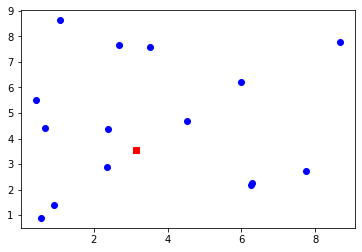

In [5]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

In [6]:
N = np.arange(1,n+1)                            # set of clients
V = np.concatenate( ([0], N, [n+1]) )           # set of nodes (depot + client)
K = np.arange(1,k+1)                            # set of vehicles
A = [(i, j) for i in V for j in V if i != j]    # arcs between nodes and vehicle k

In [7]:
node_vertices = []
for i in range(0,n+2):
    if i == 0:
        vertex = (xc[i],yc[i])
    elif i == n+1:
        vertex = (xc[0],yc[0])
    else:
        vertex = (xc[i],yc[i])

    node_vertices.append(vertex)

node_vertices = np.array(node_vertices)

In [8]:
c = {(i, j):  ( (node_vertices[i,0]-node_vertices[j,0])**2 + (node_vertices[i,1]-node_vertices[j,1])**2 )**0.5 for i, j in A} # Calculate euclidian distance between each node

q = {i: np.random.randint(1,10) for i in N}        # amount that needs to be delivered

Q =  sum( q.values() )  // len(K)  + 1 # ensure that the demand can always be fulfilled

print("totaldemand", sum( q.values() ), "Totalcapacity",Q*len(K) )

totaldemand 64 Totalcapacity 66


## Model VRP

In [9]:
from gurobipy import Model, GRB, quicksum, LinExpr, tuplelist

In [10]:
mdl = Model()
mdl.Params.TimeLimit = 100  # seconds

Using license file C:\Users\Ali Ul Haq\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17
Changed value of parameter TimeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [11]:
x = {}
for i,j in A:
    for k in K:
        x[i,j,k] = mdl.addVar(vtype=GRB.BINARY, name = "x_{}{}{}".format(i,j,k))
u = {}
for i in N:
    for k in K:
        u[i,k] = mdl.addVar(vtype=GRB.CONTINUOUS, name = "u_{}{}".format(i,k))

## *Objective function (minimization of transportation cost)*
$$min\sum_{k=1}^K \sum_{i=0}^{n} \sum_{j=1,j \neq i}^{n+1} c_{ij}x_{ij}^{k}$$

Where 
- Central depot and set of customers (nodes) $\{1,...,n\}$. Central depot is divided in origin (node $0$) and destination depot (node $n+1$)
- Fleet of vehicles $\{1,...,K\}$. $K$ number of vehicles
- Decision variable: $x_{ij}^{k} = 1$ if vehicle $k$ goes from node $i$ to node $j$

In [12]:

obj = LinExpr()

for k in K:
    for i in V:
        if i < n+1:
            for j in V:
                if j >= 1 and j != i:
                    obj += c[i,j]*x[i,j,k]

mdl.setObjective(obj, sense=GRB.MINIMIZE)

# mdl.setObjective(quicksum(quicksum(c[i, j]*x[i,j,k] for i ,j in A) for k in K))

mdl.update()



## *Constraints*

Each vehicle must leave the depot
$$\sum_{j=1}^{n+1} x_{0j}^{k}, k = 1,..., K $$ 
Each vehicle must return to the depot
$$\sum_{j=0}^{n} x_{j,n+1}^{k}, k = 1,..., K $$

In [13]:
# Each vehicle must leave the depot
for k in K:
    mdl.addConstr( quicksum(x[V[0],j,k] for j in V if j >= 1 ) == 1 , name=f"Start_{k}")

# Each vehicle must return the depot
for k in K:
    mdl.addConstr( quicksum(x[j,V[n+1],k] for j in V if j < n + 1 ) == 1 , name=f"Finish_{k}")

mdl.update()


Each customer must be visited by a vehicle: 

$$\sum_{k=1}^{K}\sum_{j=0,j \neq i}^{n} x_{ji}^{k}, i = 1,..., n $$ 


In [14]:
# Each customer must be visited by a vehicle


for i in N:
    mdl.addConstr( quicksum( quicksum(x[j,i,k] for j in V if j < n +1 and j != i) for k in K) == 1 )

mdl.update()


If a vehicle visits a customer, then the same vehicle must leave that customer: 

$$\sum_{j=0,j \neq i}^{n} x_{ji}^{k} = \sum_{j=1,j \neq i}^{n+1} x_{ij}^{k} , i = 1,..., n, k = 1,...,K $$ 


In [15]:

# If a vehicle visits a customer, then the same vehicle must leave that customer)
for i in N:
    for k in K:
        mdl.addConstr( lhs=quicksum(x[j,i,k] for j in V if j < n+1 and j!= i), sense=GRB.EQUAL, rhs= quicksum(x[i,j,k] for j in V if j >= 1 and j!= i))

mdl.update()


In [16]:
subtour_type = 'DFJ'

Subtour elimination constraint (Dantzig-Fulkerson Johnson)

$$\sum_{i\in S}\sum_{j \in S,j \neq i} x_{ij} \leq |S| - 1$$

In [17]:
def subtourelim(self, where):
    if where == GRB.callback.MIPSOL:

        active_arcs = []

        for i,j in A:
            for k in K:
                solutions = self.cbGetSolution(self._vars)
                if solutions[i,j,k] > 0.5:
                    active_arcs.append([i,j,k])

        active_arcs = np.vstack(active_arcs)

        tours = subtour(active_arcs)


        for k in tours.keys():
            if len(tours[k]) > 1:
                for tour in tours[k]:
                    S = np.unique(tour)
                    expr = quicksum(self._vars[i,j,k] for i in S for j in S if j != i)
                    self.cbLazy(expr <= len(S) - 1)

def subtour(active_arcs):
    tours = {}

    for k in K:
        vehicle_tours = []
        vehicle_arcs = active_arcs[np.where(active_arcs[:,2] == k)][:,0:2]
        start_node, finish_node = vehicle_arcs[0]
        # if finish_node == V[-1]:
        #     finish_node = V[0]

        tour = [start_node, finish_node]
        vehicle_arcs = np.delete(vehicle_arcs,[0],axis=0)

        subtour_done = 0

        while True:
            while True:
                next_node = np.where(vehicle_arcs[:,0] == finish_node)

                if next_node[0].size == 0:
                    vehicle_tours.append(tour)
                    break
                else:
                    start_node, finish_node = vehicle_arcs[next_node][0]
                    # if finish_node == V[-1]:
                    #     finish_node = V[0]
                    vehicle_arcs = np.delete(vehicle_arcs,next_node[0], axis=0)

                    tour.append(finish_node)

            if vehicle_arcs.size != 0:
                start_node, finish_node = vehicle_arcs[0]
                vehicle_arcs = np.delete(vehicle_arcs,[0], axis=0)

                # if finish_node == V[-1]:
                #     finish_node = V[0]

                tour = [start_node, finish_node]
            else:
                tours[k] = vehicle_tours
                break
        
    return tours


Subtour elimination constraint (miller-tucker-zemlin)

$$u_{j} - u_{i} \geq q_{j} - Q(1-x_{ijk}), i,j = \{1,....,n\}, i \neq j$$

In [18]:
# Miller-Tucker-Zemlin formulation for subtour elimination

if subtour_type == 'MTZ':
    for k in K:
        for i,j in A:
            if i >= 1 and j >= 1:
                if i != n+1 and j != n+1:
                    mdl.addConstr( u[j,k] - u[i,k] >= q[j] - Q*(1 - x[i,j,k]) )

    # Capacity constraint
    for i in N:
        for k in K:
            mdl.addConstr(u[i,k] >= q[i])
            mdl.addConstr(u[i,k] <= Q)
            
# DFJ formulation for subtour elimination
elif subtour_type == 'DFJ':
    for k in K:
        mdl.addConstr( quicksum(quicksum(q[j]*x[i,j,k] for j in N if j !=i) for i in V if i < n + 1) <= Q )


mdl.update()

In [19]:
mdl.write('test.lp')
mdl._vars = x

### OPTIMIZE

In [20]:
if subtour_type == "MTZ":

    mdl.optimize()
elif subtour_type == "DFJ":
    mdl.Params.lazyConstraints = 1
    mdl.optimize(subtourelim)


Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 51 rows, 574 columns and 1864 nonzeros
Model fingerprint: 0x12d9fafd
Variable types: 30 continuous, 544 integer (544 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [9e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve time: 0.01s
Presolved: 51 rows, 574 columns, 1864 nonzeros
Variable types: 30 continuous, 544 integer (544 binary)

Root relaxation: objective 2.469947e+01, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.69947    0   14          -   24.69947      -     -    0s
     0     0   24.69947    0   24          -   24.69

In [21]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [22]:
active_arcs = []
for i,j in A:
    for k in K:
        if x[i,j,k].x > 0.99:
            active_arcs.append([i,j,k])

active_arcs = np.vstack(active_arcs)

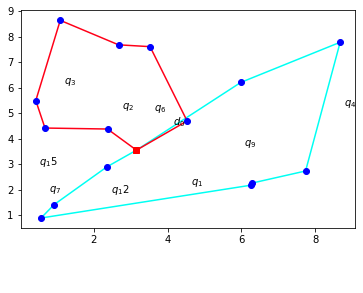

In [23]:
cmap = get_cmap(len(K)+1)

for k in K:
    vehicle_arcs = active_arcs[ np.where(active_arcs[:,2] == k) ]
    for i, j, k_ in vehicle_arcs:
        plt.plot([node_vertices[i,0], node_vertices[j,0]], [node_vertices[i,1], node_vertices[j,1]], c = cmap(k), zorder=0)

# plot depot
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.annotate("$d_{}$".format(V[0]),(xc[0]+1,yc[0]+1) )

# plot customers
plt.scatter(xc[1:], yc[1:], c='b')
for i in N:
    plt.annotate("$q_{}$".format(i), (xc[i]+0.1,yc[i]-2.5) )